### Box 6, Step 1	
Batch-process the data set into x-y-image files organized into a hypercube with z, λ, and t encoded as axis labels. To reduce the size of the resulting data set and speed up to subsequent steps, we have implemented a keyword argument that allows binning (Supplementary Code 3, Cell 1). 

In [1]:
from hyperspectralTracking import * #tracking data class and dependencies

#just for style
display(HTML("<style>.container { width:80% !important; }</style>"))

#define location and name of dataset
directoryName='D:\\Protocol_SICode3\\'
logName='Log_2022-12-08_07-09AM_toShare.txt'
dataName='Keras3-Scan0-'

#create an instance of the acquisition class to run the auto-calibration routine
Scan0=acquisition(directoryName, dataName)
Scan0.autoCalibrate(logName, FOV50=693.54)

#create a folder called 'processedND' in your working directory prior to running this
#batch-process the stack. binning can be applied to reduce the output file size and improve SNR
Scan0.batchProcessND(nBin=np.array([1, 1, 4, 2]), upLim=300, lowLim=10) #nBin=[bin_x, bin_y, bin_w, bin_z]

processing stack 1 out of 6
processing stack 2 out of 6
processing stack 3 out of 6
processing stack 4 out of 6
processing stack 5 out of 6
processing stack 6 out of 6


### Step 2	
Add all processed files to a .zip folder by specifying source directory and filename identifier (Supplementary Code 3, Cell 2). You can now delete the batch-processed images from the directory.

▲ CRITICAL Ensure no additional files with the same filename identifier are in the working directory.

In [2]:
directory=Scan0.directory+'processedND\\'
file = directory+"I_total.zip"  # zip file name
with ZipFile(file, 'w') as zip:
    for path, directories, files in os.walk(directory):
        for file in files:
            file_name = os.path.join(path, file)
            if (Scan0.name+'Imap') in file_name:
                zip.write(file_name) # zipping the file

### Step 3	
Feed the .zip folder into the ND tracking algorithm TrackPY53 and run the batch-autodetection. The 'batch' method detects objects at each individual timestep by grouping pixels with similar positional and wavelength values into one object (Supplementary Code 3, Cell 3).

In [3]:
#load the data as ND image sequence
frames = pims.ImageSequenceND(r'D:\\Protocol_SICode3\\processedND\\I_total.zip', axes_identifiers = ['z','w','t'])
frames.bundle_axes = ['w','z', 'y', 'x']
frames

#batch-autodetect the features for all timepoints, specifying the expected dimensions in x-y-w-t
f = tp.batch(frames, diameter=(3, 3, 3, 3), characterize=False)

Frame 5: 69 features


### Step 4	
Run the linking algorithm to track the detected objects across multiple timesteps and export the results as Excel spreadsheet (Supplementary Code 3, Cell 4). The algorithm will return the tracked centroids of objects in the x-y-z-λ-t parameter space.

In [4]:
#set some weights and spatial characteristics
weight=0.0001
f['xum'] = f['x3'] * Scan0.xStep * 3
f['yum'] = f['x2'] * Scan0.yStep * 3 
f['zum'] = f['x1'] * Scan0.zStep * 2
f['wum'] = f['x0'] * weight

#link the tracked objects and save the results
tolerance=30
linked = tp.link_df(f, tolerance, pos_columns=['xum', 'yum', 'zum', 'wum'])
linked.to_csv(Scan0.directory+Scan0.name+'NDtrack.csv')

Frame 5: 69 trajectories present.


### Step 5	
Create an instance of the trackingData class, which organizes the output from the tracking algorithm, using the name of the tracking data file as an input argument, and the acquisition object created during Box 6, Step 1 (Supplementary Code 3, Cell 5).

In [5]:
area=0
#read the tracking results from the organized csv file
linked=read_csv(Scan0.directory+Scan0.name+'NDtrack.csv')
databaseND=trackDataND(linked,Scan0, name='A{}_ND'.format(area))

### Step 6
Display trajectories as images or extract traces of position or wavelength of individual tracked LPs (Supplementary Code 3, Cell 6).

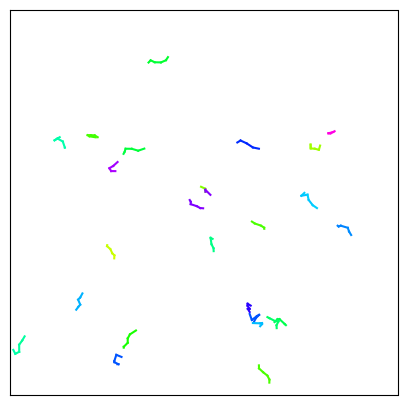

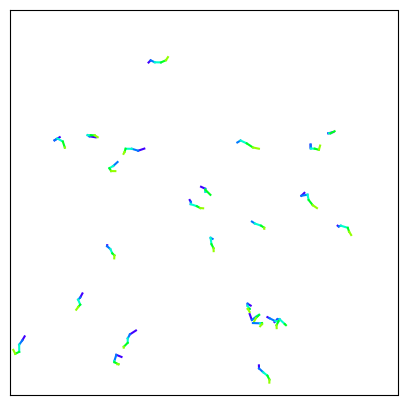

In [6]:
length=4
databaseND.plotTrajs(Scan0, minLen=length, colorCode='wL', nBin=[1,1,4,2])
databaseND.plotTrajs(Scan0, minLen=length, colorCode='time', nBin=[1,1,4,2])

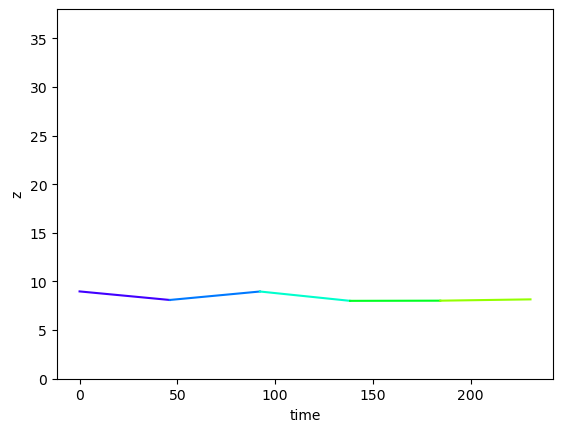

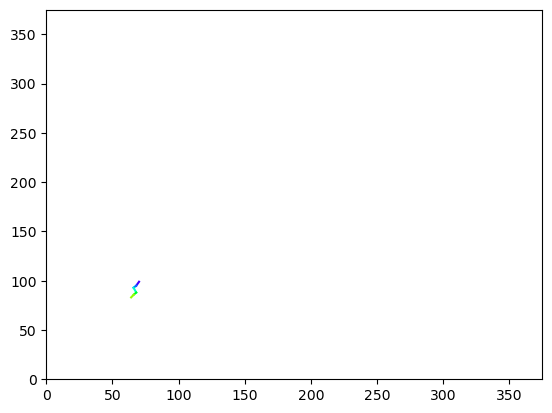

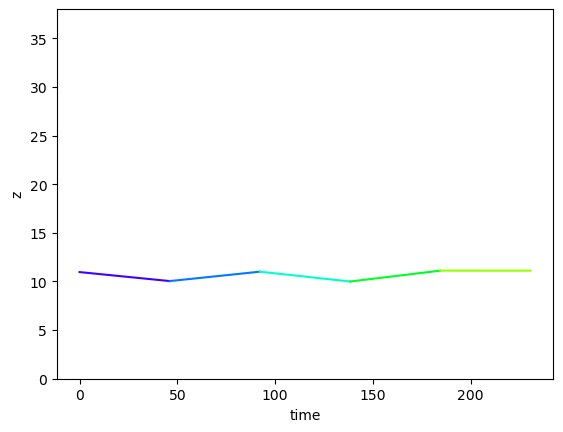

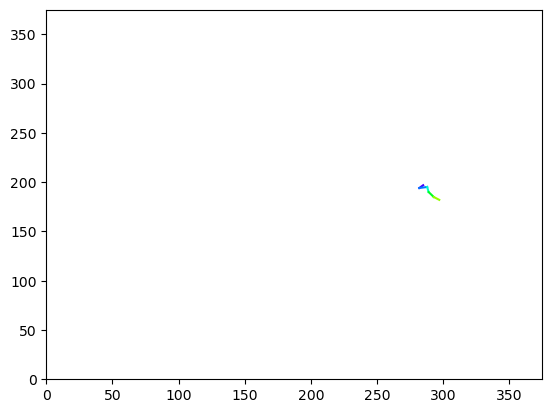

In [7]:
#example of upward migrating cell in skin layer
LPi=databaseND.disks['A0_ND7']
LPi.plotTraj(Scan0, ax0='z')
LPi.plotXY(Scan0, colorCode='time', nBin=[1,1,4,2])

#example of stationary cell in skin layer
LPi=databaseND.disks['A0_ND12']
LPi.plotTraj(Scan0, ax0='z')
LPi.plotXY(Scan0, colorCode='time', nBin=[1,1,4,2])
